# A Simple Quantum Estimator

_This notebook explores the creation and use of a quantum estimator in **PennyLane and PyTorch**_.

**By:** Jacob Cybulski ([website](https://jacobcybulski.com/))<br>
**Date:** 1 October 2024<br>
**Aims:** To develop a simple quantum estimator in PennyLane, and compare it with its PyTorch classical version<br/>
**License:** 
This project is licensed under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/)<br>
**Changes:** All changes to this code must be listed at the bottom of this notebook

## Libraries

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/lib/python311.zip',
 '/home/jacob/miniconda3/lib/python3.11',
 '/home/jacob/miniconda3/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/venv/pl/lib/python3.11/site-packages',
 '.']

In [2]:
### General libraries

import os
import pylab
import math
import time
import copy
import numpy as nnp
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
### Import utilities
from utilities import *

In [4]:
### Import PennyLane and Torch
import pennylane as qml
from pennylane import numpy as np
from pennylane import NesterovMomentumOptimizer
from torch import nn
from torch.autograd import Variable
import torch

## Load previously prepared data set

Data set (requires: pip install sklearn):
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes" target="_blank">Diabetes</a>:
Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.  
  
_**Data prepared according to the following objectives:**_

- *Fetch and understand data*
- *Select numeric variables only (not needed)*
- *Deal with missing values (not needed)*
- *Analyse the target*
- *Standardise both predictors and target*
- *Reduce dimensionality using PCA*


### Files location

In [5]:
RSRC_STORE = 'rsrc'
RSRC_NAME = 'diabetes'
PLOTS_PATH = 'plots'

### Data set in its original form

In [6]:
from sklearn import datasets
bunch = datasets.load_diabetes(return_X_y=False, as_frame=True, scaled=False)
print(bunch.DESCR)
X_y = bunch.frame

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [7]:
X_y.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


### Load data from the store

In [8]:
x_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_x.pkl')
y_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_y.pkl')
X_pca = pd.read_pickle(x_file_path)
y = pd.read_pickle(y_file_path)
print(f'\nRead previously prepared data set:   "{RSRC_NAME}" in store "{RSRC_STORE}"\n')


Read previously prepared data set:   "diabetes" in store "rsrc"



In [9]:
### Sample of saved X predictors
nnp.round(X_pca[0:5], 3)

,PC00,PC01,PC02,PC03,PC04,PC05,PC06,PC07
0,0.554,-0.073,0.110,-0.258,0.111,-0.149,0.070,0.128
1,-0.609,-0.280,0.133,0.195,-0.002,-0.184,-0.057,-0.002
2,0.542,-0.108,0.261,-0.140,0.285,-0.155,0.108,0.125
3,-0.452,0.107,-0.483,0.014,-0.027,0.051,-0.086,-0.017
4,-0.469,0.047,0.060,0.076,0.009,-0.151,-0.160,-0.126


In [10]:
### Sample of saved y target
y[0:5]

,target
0,0.392523
1,0.155763
2,0.361371
3,0.563863
4,0.342679


## Create a simple quantum model

### Utilities

In [11]:
### Performance measures
from torcheval.metrics.functional import r2_score as torch_r2

def square_loss(labels, predictions):
    sq_diffs = torch.tensor([(l - p)**2 for l, p in zip(labels, predictions)])
    return sq_diffs.mean().item()

def r2_score(y_true, y_pred):
    r2 = torch_r2(y_true, y_pred)
    return r2
    
### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define device to compute on

In [12]:
### Find what devices are available

# Type to be used with tensors
dtype = torch.float64
torch.set_default_dtype(dtype)

# Quantum simulator
sim = 'lightning.qubit' # default.qubit lightning.qubit lightning.gpu

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'\nThe optimum devices: {sim} and {torch_device}')

# Force CPU to avoid moving computation and data back and from the GPU
torch_device = "cpu"

print(f'Devices to be used:  {sim} and {torch_device}\n')


The optimum devices: lightning.qubit and cpu
Devices to be used:  lightning.qubit and cpu



### Model and training configuration

In [13]:
### Data params
data_frac = 1.0 # so that we would not need to wait 

n_data = 5 # See PCA
x_angle_margin = 0.1
x_angle_min = 0+x_angle_margin
x_angle_max = nnp.pi-x_angle_margin

### Architectural params
n_wires = n_data
n_layers = 5
scaler = 1
wires = list(range(n_wires))

### Training params
epochs = 150
log_interv = 1
prompt_fract = 0.05
acc_prec = 0.5
shots = 1000
seed = 2024

### Prepare data for the quantum classifier

In [14]:
### Check ranges
print(f'Min X={X_pca.to_numpy().min().round(3)}, Max X={X_pca.to_numpy().max().round(3)}, '+\
      f'Min y={y.to_numpy().min().round(3)}, Max y={y.to_numpy().max().round(3)}')

Min X=-0.827, Max X=0.998, Min y=0.0, Max y=1.0


In [15]:
### Standardise X values to the range 0..pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
angle_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
X_scaled = pd.DataFrame(angle_scaler.fit_transform(X_pca), columns=X_pca.columns)

In [16]:
### Take a smaller sample of data

X_y_sample = pd.concat([X_scaled, y], axis=1).sample(frac=data_frac)

### Separate X and y
y = X_y_sample['target'].to_frame()
X = X_y_sample.drop('target', axis=1)

# Recheck the X ranges
print(f'Min X={X.to_numpy().min().round(3)}, Max X={X.to_numpy().max().round(3)}, '+\
      f'Min y={y.to_numpy().min().round(3)}, Max y={y.to_numpy().max().round(3)}')

Min X=0.1, Max X=3.042, Min y=0.0, Max y=1.0


In [17]:
### Create data partitions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:n_data], y.iloc[:,0:n_data], 
                                                    test_size=0.33, random_state=seed)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(296, 5), X_test=(146, 5), y_train=(296, 1), y_test=(146, 1)


In [18]:
### Change the data format to tensors
X_train_tens = torch.tensor(np.array(X_train), dtype=torch.double)
y_train_tens = torch.tensor(np.array(y_train), dtype=torch.double)
X_test_tens  = torch.tensor(np.array(X_test), dtype=torch.double)
y_test_tens  = torch.tensor(np.array(y_test), dtype=torch.double)

In [19]:
### Sample training predictors
print(X_train_tens[0:5])

tensor([[2.3529, 1.0007, 2.2183, 2.2912, 1.6754],
        [2.5057, 1.1120, 1.2292, 2.0580, 2.5300],
        [2.6684, 1.5920, 1.7530, 1.6690, 1.7395],
        [0.5112, 1.6535, 2.3373, 2.0109, 1.3314],
        [2.4274, 0.9689, 1.6241, 1.5536, 2.3956]])


In [20]:
### Sample training labels
y_train_tens[0:5]

tensor([[0.2056],
        [0.1371],
        [0.8910],
        [0.5888],
        [0.3738]])

### PyTorch model with a PennyLane layer

In [21]:
### Create a PyTorch model with a PennyLane circuit within

class Quantum_Diabetes(nn.Module):

    def __init__(self, sim, n_data, n_layers=1, shots=0, scaler=np.pi, meas_wires=[0]):
        super(Quantum_Diabetes, self).__init__()

        self.sim = sim
        self.n_data = n_data
        self.n_wires = n_data
        self.n_layers = n_layers
        self.wires = list(range(n_wires))
        self.shots = shots
        self.scaler = scaler
        self.meas_wires = meas_wires

        # Create a PennyLane quantum model 
        def_qlayer = self.qlayer()

        # Wrap a torch layer around the PennyLane model
        layers = [def_qlayer]
        self.model = nn.Sequential(*layers)  

    ### Define a quantum layer
    def qlayer(self):
        
        # Specify a device, note that not all devices accept "shots"
        if self.shots == 0:
            dev = qml.device(self.sim, wires=self.n_wires)
        else:
            dev = qml.device(self.sim, wires=self.n_wires, shots=self.shots)

        # Define the model weights shape
        weights_shapes = {"weights": self.qshape()}

        # Define the quantum model and its circuit (save it for later)
        model = self.qmodel()
        self.model_qc = qml.QNode(model, dev, interface='torch')

        # Turn the circuit into a Torch layer (to be returned)
        qlayer = qml.qnn.TorchLayer(self.model_qc, weight_shapes=weights_shapes)
        return qlayer

    ### Define a quantum model
    def qmodel(self):
        def _qmodel(inputs, weights):
            data_wires = wires[0:self.n_data]
            scaled_inputs = torch.mul(inputs, self.scaler)
            qml.AngleEmbedding(scaled_inputs, wires=data_wires)        
            qml.StronglyEntanglingLayers(weights, wires=data_wires)
            return [qml.expval(qml.PauliZ(m)) for m in self.meas_wires]
        return _qmodel

    ### Return the quantum model circuit
    def qmodel_qc(self):
        return self.model_qc
 
    ### Return the model shape
    def qshape(self):
        shape = qml.StronglyEntanglingLayers.shape(n_layers=self.n_layers, n_wires=self.n_wires)
        return shape
 
    ### Apply the model to data (forward step)
    def forward(self, x):
        y = self.model(x)
        return y

### Test the PennyLane/PyTorch model before use

In [22]:
### Create a test model and draw the test model circuit
test = Quantum_Diabetes(sim, X_train_tens.shape[1], n_layers=n_layers, shots=shots, scaler=scaler).double().to(torch_device)

### Show the structure of the torch model
test.eval()

Quantum_Diabetes(
  (model): Sequential(
    (0): <Quantum Torch Layer: func=_qmodel>
  )
)

In [23]:
### Prepara an example of input and weights suitable for the classifier
shape = test.qshape()
n_weights = np.prod(shape)
weights = torch.rand(shape, requires_grad=True)

print(f'QM shape ({n_weights} weights): {shape} , Epochs: {epochs}, Shots: {shots}, Seed: {seed}\n')
print(X_train_tens[0:5], '\n')
print(weights, '\n')

QM shape (75 weights): (5, 5, 3) , Epochs: 150, Shots: 1000, Seed: 2024

tensor([[2.3529, 1.0007, 2.2183, 2.2912, 1.6754],
        [2.5057, 1.1120, 1.2292, 2.0580, 2.5300],
        [2.6684, 1.5920, 1.7530, 1.6690, 1.7395],
        [0.5112, 1.6535, 2.3373, 2.0109, 1.3314],
        [2.4274, 0.9689, 1.6241, 1.5536, 2.3956]]) 

tensor([[[0.0267, 0.9586, 0.6962],
         [0.3988, 0.1277, 0.3172],
         [0.5303, 0.4524, 0.5051],
         [0.3545, 0.1503, 0.8824],
         [0.1765, 0.7644, 0.8382]],

        [[0.5004, 0.9081, 0.0489],
         [0.5617, 0.9227, 0.9448],
         [0.9334, 0.1001, 0.7569],
         [0.0532, 0.7322, 0.4797],
         [0.1717, 0.6110, 0.9835]],

        [[0.8177, 0.7491, 0.6958],
         [0.8672, 0.6103, 0.9671],
         [0.2703, 0.2147, 0.1205],
         [0.0751, 0.1479, 0.3807],
         [0.5269, 0.9513, 0.9191]],

        [[0.2866, 0.8870, 0.5111],
         [0.0916, 0.4530, 0.2871],
         [0.3981, 0.7896, 0.1958],
         [0.4187, 0.3780, 0.7188],
   

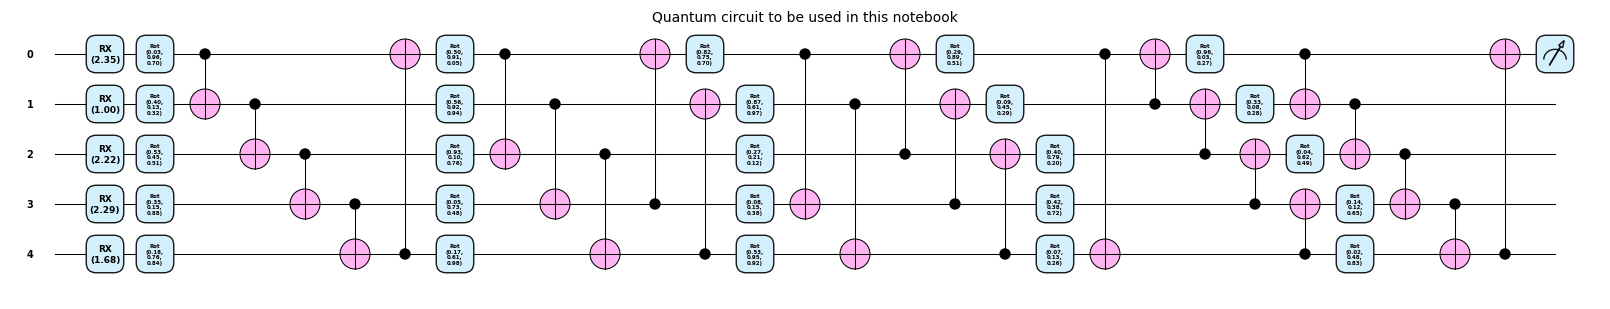

In [24]:
### Draw the test model circuit
draw_circuit(test.qmodel_qc(), scale=0.5, title='Quantum circuit to be used in this notebook', level='device') \
    (X_train_tens[0], weights) # level='device'/'gradient'

In [25]:
### Test if the model works as a function
test(X_train_tens[0:5])

tensor([[-0.0420],
        [-0.1560],
        [-0.1000],
        [-0.3480],
        [-0.0420]], grad_fn=<ViewBackward0>)

### Creation and training of the actual PennyLane/PyTorch model

In [26]:
### Trains the classical AE model

def train_quantum(model, X, y, cost_fun, score_fun, optimizer, epochs, 
                  log_interv=100, prompt_fract=0.1, start_time=0):
    # global history, r2_hist, opt_params, hist_params
    
    cost_hist = []
    r2_hist = []
    opt_params = {}
    hist_params = []
    min_epoch = 0
    min_cost = 1000
    max_r2 = -1000
    if start_time == 0: start_time = time.time()
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(X)
        cost = cost_fun(output, y)
        r2 = score_fun(output, y)
        cost.backward()
        optimizer.step()

        curr_loss = cost.item()
        curr_r2 = r2
        if curr_loss < min_cost: 
            min_cost = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if curr_r2 > max_r2:
            max_r2 = curr_r2

        if epoch % log_interv == 0:
            cost_hist.append(curr_loss)
            r2_hist.append(curr_r2)
            hist_params.append(copy.deepcopy(model.state_dict()))

        elapsed = time.time() - start_time
        if (prompt_fract == 0) or (epoch % int(prompt_fract*epochs) == 0):
            print(f'{epoch: 5d} '+ \
                  f'({elapsed:06.0f} sec): '+ \
                  f'Loss {curr_loss:06.4f}   '+ \
                  f'R2 {curr_r2:06.4f}')
            
    return cost_hist, r2_hist, opt_params, hist_params, (min_epoch, min_cost)


In [27]:
### Set up the training run
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
q_diabetes = Quantum_Diabetes(sim, X_train_tens.shape[1], n_layers=n_layers, shots=shots, scaler=scaler).double().to(torch_device)

### Loss and optimiser

# cost_fun = nn.L1Loss() # Very poor results
cost_fun = nn.MSELoss()

# opt = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
# opt = torch.optim.Adam(q_diabetes.parameters())
opt = torch.optim.NAdam(q_diabetes.parameters(), lr=0.01)

In [28]:
### Train the model

torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f'\nModel training started\n')
start_time = time.time()

train_mse_hist, train_r2_hist, opt_params, hist_params, opt_point = \
    train_quantum(q_diabetes, X_train_tens, y_train_tens, cost_fun, r2_score, opt, epochs, 
                  log_interv=log_interv, prompt_fract=prompt_fract)

elapsed = time.time() - start_time
print(f'\nTotal training time: {int(elapsed)}s ({time.strftime("%H:%M:%S", time.gmtime(elapsed))})')


Model training started

    0 (000028 sec): Loss 0.2354   R2 -2.8863
    7 (000205 sec): Loss 0.0988   R2 -0.6319
   14 (000383 sec): Loss 0.0599   R2 0.0105
   21 (000561 sec): Loss 0.0525   R2 0.1332
   28 (000739 sec): Loss 0.0478   R2 0.2106
   35 (000916 sec): Loss 0.0453   R2 0.2516
   42 (001093 sec): Loss 0.0429   R2 0.2915
   49 (001268 sec): Loss 0.0411   R2 0.3217
   56 (001442 sec): Loss 0.0409   R2 0.3246
   63 (001616 sec): Loss 0.0395   R2 0.3486
   70 (001790 sec): Loss 0.0386   R2 0.3633
   77 (001965 sec): Loss 0.0371   R2 0.3869
   84 (002140 sec): Loss 0.0389   R2 0.3574
   91 (002315 sec): Loss 0.0376   R2 0.3799
   98 (002489 sec): Loss 0.0357   R2 0.4104
  105 (002664 sec): Loss 0.0350   R2 0.4220
  112 (002838 sec): Loss 0.0343   R2 0.4335
  119 (003013 sec): Loss 0.0348   R2 0.4248
  126 (003187 sec): Loss 0.0333   R2 0.4508
  133 (003361 sec): Loss 0.0348   R2 0.4256
  140 (003537 sec): Loss 0.0342   R2 0.4348
  147 (003711 sec): Loss 0.0333   R2 0.4510

Tota

### Calculate optimum scores

In [29]:
### Accumulate test scores
test_mse_hist = []
test_r2_hist = []

### Find training loss and R2
train_min_mse = nnp.min(train_mse_hist)
train_min_mse_iter = nnp.argmin(train_mse_hist)
train_max_r2 = nnp.max(train_r2_hist)
train_max_r2_iter = nnp.argmax(train_r2_hist)

### Initialise testing loss and R2
test_min_mse = 1000
test_min_mse_iter = -1
test_max_r2 = 0
test_max_r2_iter = -1

### Calculate testing loss and R2
for iter in range(len(hist_params)):
    q_diabetes.load_state_dict(hist_params[iter])
    test_pred = q_diabetes(X_test_tens)
    curr_r2 = r2_score(test_pred, y_test_tens)
    curr_loss = square_loss(test_pred, y_test_tens)
    test_r2_hist.append(curr_r2)
    test_mse_hist.append(curr_loss)
    if curr_r2 > test_max_r2:
        test_max_r2 = curr_r2
        test_max_r2_iter = iter
    if curr_loss < test_min_mse:
        test_min_mse = curr_loss
        test_min_mse_iter = iter

In [30]:
# Print run statistics
shape = q_diabetes.qshape()
n_weights = np.prod(shape)
time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))

print(f'\n'+
      f'Run Summary:\t'+
      f'devices = {torch_device} + {sim}\n\t\t'+
      f'samples = {y_train_tens.shape[0]}, '+
      f'features = {X_train_tens.shape[1]}, '+
      f'params = {count_params(q_diabetes)}, '+
      f'epochs = {epochs}\n\t\t'+
      f'training: cost = {nnp.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'r2 = {nnp.round(train_max_r2, 5):05.4f} @ {train_max_r2_iter:04d}\n\t\t'+
      f'testing:  cost = {round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}, '+
      f'r2 = {nnp.round(test_max_r2, 5):05.4f} @ {test_max_r2_iter:04d}\n\t\t'+
      f'elapsed time = {elapsed:0.0f}sec ({time_str})'+
      f'\n'
     )


Run Summary:	devices = cpu + lightning.qubit
		samples = 296, features = 5, params = 75, epochs = 150
		training: cost = 0.0333 @ 0147, r2 = 0.4510 @ 0147
		testing:  cost = 0.0317 @ 0142, r2 = 0.3811 @ 0142
		elapsed time = 3761sec (01:02:41)



### Plot costs and scores

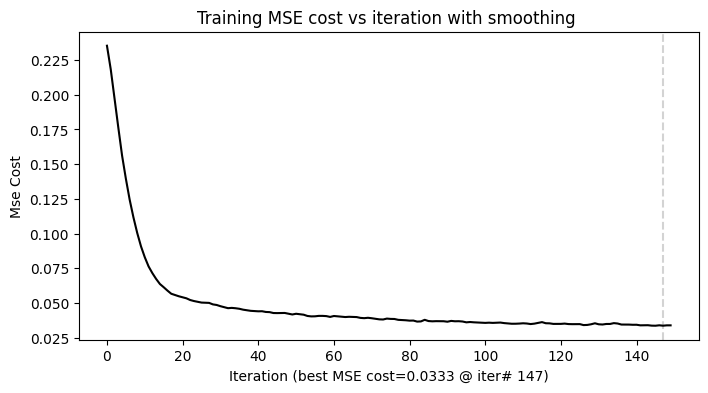

In [31]:
### Plot training cost
meas_plot(train_mse_hist, meas='MSE cost', task='min', title_pref='Training',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.5,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtrain_mse.eps")}')

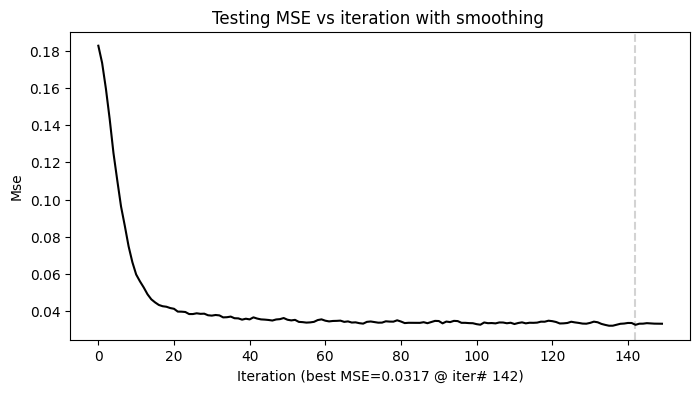

In [32]:
### Plot test cost
meas_plot(test_mse_hist, meas='MSE', task='min', title_pref='Testing',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.5,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtest_mse.eps")}')

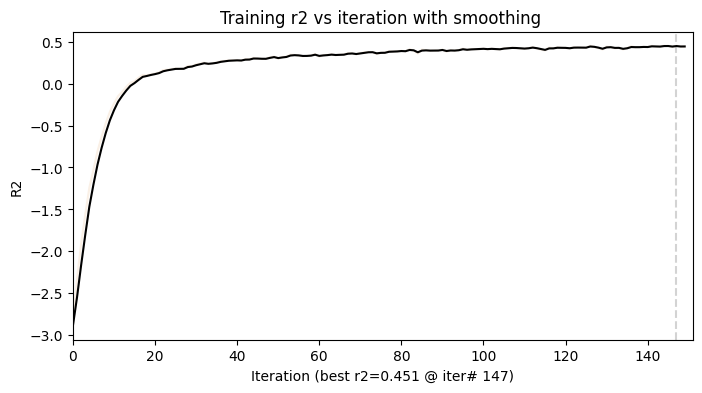

In [33]:
### Plot training accuracy
meas_plot(train_r2_hist, meas='r2', task='max', title_pref='Training',
                  rcParams=(8, 4), log_interv=log_interv, xlim=(0, epochs+1), #ylim=(0.4, 0.9),
                  backplot=True, back_color='linen', smooth_weight=0.4,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtrain_acc.eps")}')

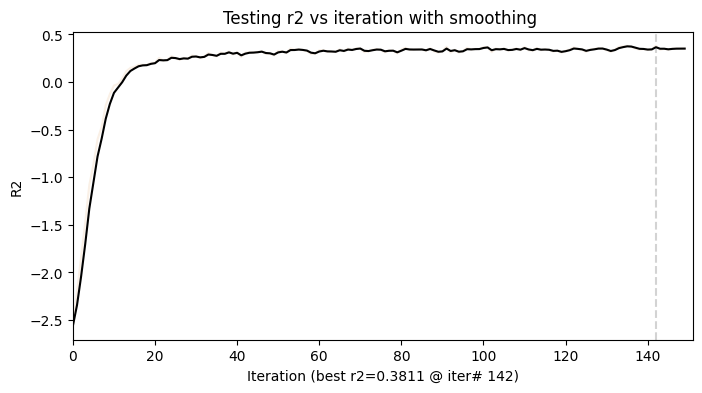

In [34]:
### Plot testing accuracy
meas_plot(test_r2_hist, meas='r2', task='max', title_pref='Testing',
                  rcParams=(8, 4), log_interv=log_interv, xlim=(0, epochs+1), #ylim=(0.35, 0.95),
                  backplot=True, back_color='linen', smooth_weight=0.4,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtest_acc.eps")}')

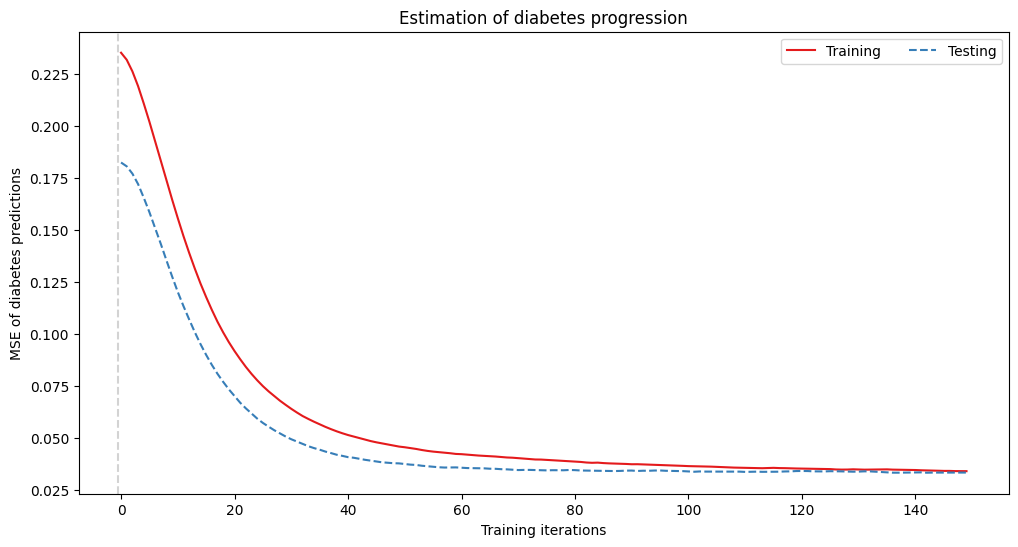

In [35]:
multi_plot_series(
    [train_mse_hist, test_mse_hist], X_list=[0, 0], labels=['Training', 'Testing'], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='MSE of diabetes predictions',
    legend_cols=2, smooth_weight=0.9, title='Estimation of diabetes progression',
    save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtrain_qtest_mse.eps")}')

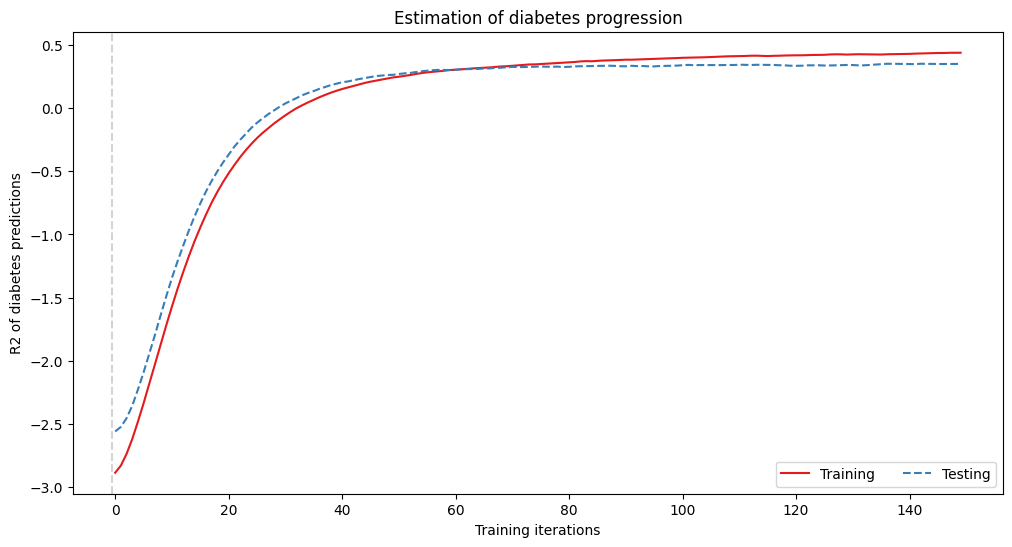

In [36]:
multi_plot_series(
    [train_r2_hist, test_r2_hist], X_list=[0, 0], labels=['Training', 'Testing'], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='R2 of diabetes predictions',
    legend_cols=2, smooth_weight=0.9, title='Estimation of diabetes progression',
    save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtrain_qtest_r2.eps")}')

### Save the training information for further analysis

In [37]:
### Save all training and scoring results
import pickle

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_qopt_params.pkl'), 'wb') as f:
    pickle.dump(opt_params, f, pickle.HIGHEST_PROTOCOL); f.close()
    
with open(os.path.join(RSRC_STORE, RSRC_NAME+'_qhist_params.pkl'), 'wb') as f:
    pickle.dump(hist_params, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_qopt_point.pkl'), 'wb') as f:
    pickle.dump(opt_point, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_qtrain_mse_hist.pkl'), 'wb') as f:
    pickle.dump(train_mse_hist, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_qtest_mse_hist.pkl'), 'wb') as f:
    pickle.dump(test_mse_hist, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_qtrain_r2_hist.pkl'), 'wb') as f:
    pickle.dump(train_r2_hist, f, pickle.HIGHEST_PROTOCOL); f.close()

with open(os.path.join(RSRC_STORE, RSRC_NAME+'_qtest_r2_hist.pkl'), 'wb') as f:
    pickle.dump(test_r2_hist, f, pickle.HIGHEST_PROTOCOL); f.close()

print(f'\nSaved all training and scoring results:   "{RSRC_NAME}" in store "{RSRC_STORE}"')
print(f'To read the data set back use: "df = pd.read_pickle(file_path)"')


Saved all training and scoring results:   "diabetes" in store "rsrc"
To read the data set back use: "df = pd.read_pickle(file_path)"


## What's next?
*At this point you can improve this notebook by performing the following tasks:*

- Save the history of loss and accuracy into a resource folder
- Save all model parameters kept during the model training into a resource folder
- Play with the smoothing factor in all plots to gain insight into volatility of your scores
- Analyse all accumulated data and report your observations, reflect on your learning

*As an extension:*

- Prepare an Automobile data set, a model and its scores, to predict car price (exclude symboling which is a variable dependent on price)
- Repeat the entire process for the "sonar" data set (link included above)
- Enjoy learning predictive analytics using classical and quantum ML models

## Modifications (do not remove)
Under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/) license, if you perform any changes to this notebook, please list them here, adding a note with your name, contact details, date and changes to the code.

- [Jacob Cybulski](http://jacobcybulski.com) (2024, 1 Oct): The author of this notebook added this section to record all code changes
- [Jacob Cybulski](http://jacobcybulski.com) (2024, 3 Mar): PennyLane v0.40 and Torch 2.6 compatibility

## Systems in use

In [38]:
!pip list | grep -e PennyLane -e torch

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
torch                     2.6.0+cpu
torchaudio                2.6.0+cpu
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cpu
